In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def create_bandit_setup(N=10):
    # create N arms from a set distribution
    arm_means = np.ones(shape=N)
    arm_counts = np.zeros(shape=N)
    arm_estimates = np.zeros(shape=N)
    return arm_means, arm_counts, arm_estimates

def draw_reward(action, arm_means, arm_counts):
    selected_mean = arm_means[action]
    reward = np.random.normal(loc=selected_mean)
    arm_counts[action] = arm_counts[action] + 1
    # add random walk element
    arm_means = arm_means + np.random.normal(scale=0.01, size=(arm_means.size))
    return reward, arm_means, arm_counts

def update_sample_average(action, reward, arm_counts, arm_estimates):
    arm_estimates[action] = arm_estimates[action] + (1.0/arm_counts[action]) * (reward - arm_estimates[action])
    return arm_estimates

def update_const_step(action, reward, arm_counts, arm_estimates, step_size=0.1):
    arm_estimates[action] = arm_estimates[action] + (step_size) * (reward - arm_estimates[action])
    return arm_estimates

def eps_greedy_action(arm_means, arm_estimates, eps=0.1):
    opt_action = np.argmax(arm_means)
    if np.random.binomial(1, eps) == 1:
        rand_action = np.random.randint(low=0, high=arm_estimates.size)
        return rand_action, rand_action == opt_action
    else:
        action = np.argmax(arm_estimates)
        return action, action == opt_action

In [ ]:
N_steps = 10000
N_runs = 100

sample_average_average_rewards = np.zeros(shape=(N_runs, N_steps))
sample_average_optimal_action_selected = np.zeros(shape=(N_runs, N_steps))

for exp_indx in range(N_runs):
    arm_means, arm_counts, arm_estimates = create_bandit_setup()
    for t in range(N_steps):
        action, is_optimal = eps_greedy_action(arm_means, arm_estimates)
        sample_average_optimal_action_selected[exp_indx, t] = is_optimal
        reward, arm_means, arm_counts = draw_reward(action, arm_means, arm_counts)
        arm_estimates = update_sample_average(action, reward, arm_counts, arm_estimates)
        
        if t == 0:
            sample_average_average_rewards[exp_indx, t] = reward
        else:
            # increment sample average formula
            sample_average_average_rewards[exp_indx, t] = sample_average_average_rewards[exp_indx, t-1] + (1.0/t) \
                                                            * (reward - sample_average_average_rewards[exp_indx, t-1])            
# not great code practice, but this is a small exercise. Lets just copy and paste for the other one!

step_average_rewards = np.zeros(shape=(N_runs, N_steps))
step_optimal_action_selected = np.zeros(shape=(N_runs, N_steps))

for exp_indx in range(N_runs):
    arm_means, arm_counts, arm_estimates = create_bandit_setup()
    for t in range(N_steps):
        action, is_optimal = eps_greedy_action(arm_means, arm_estimates)
        step_optimal_action_selected[exp_indx, t] = is_optimal
        reward, arm_means, arm_counts = draw_reward(action, arm_means, arm_counts)
        arm_estimates = update_const_step(action, reward, arm_counts, arm_estimates)
        if t == 0:
            step_average_rewards[exp_indx, t] = reward
        else:
            # increment sample average formula
            step_average_rewards[exp_indx, t] = step_average_rewards[exp_indx, t-1] + (1.0/t) \
                                                            * (reward - step_average_rewards[exp_indx, t-1])    

In [ ]:
sample_average_mean_reward = np.mean(sample_average_average_rewards, axis=0)
sample_average_std_reward = np.std(sample_average_average_rewards, axis=0)
sample_average_mean_opt = np.mean(sample_average_optimal_action_selected, axis=0)
sample_average_std_opt = np.std(sample_average_optimal_action_selected, axis=0)

step_mean_reward = np.mean(step_average_rewards, axis=0)
step_std_reward = np.std(step_average_rewards, axis=0)
step_mean_opt = np.mean(step_optimal_action_selected, axis=0)
step_std_opt = np.std(step_optimal_action_selected, axis=0)

In [ ]:
plt.figure(figsize=(6, 3), dpi=160)
plt.plot(sample_average_mean_reward, label="Sample Mean")
plt.fill_between(np.arange(N_steps), sample_average_mean_reward - sample_average_std_reward, 
                  sample_average_mean_reward + sample_average_std_reward, alpha=0.25)
plt.plot(step_mean_reward, label=r"$\alpha=0.1$")
plt.fill_between(np.arange(N_steps), step_mean_reward - step_std_reward, 
                  step_mean_reward + step_std_reward, alpha=0.25)
plt.xlabel("$t$")
plt.ylabel("Average Reward")
plt.legend();
plt.savefig('rewards.pdf')

In [ ]:
plt.figure(figsize=(6, 3), dpi=160)
plt.plot(sample_average_mean_opt, label="Sample Mean")
plt.plot(step_mean_opt, label=r"$\alpha=0.1$")
plt.xlabel("$t$")
plt.ylabel("opt action chosen?")
plt.legend()
plt.savefig('choices.pdf')

# Exercise 2.11

We now want to compare different algorithms with hyperparameters.

Let's compare:

* greedy with optimistic initialisation
* $\epsilon$-greedy
* UCB

with $N_{step} = 200000$, using the average reward over the last $100000$ steps as the metric.

The randomness in the walk is probably important so I will want to be using the same random seeds for the walk. However, this could be annoying since the epsilon greedy action will take more random steps, throwing the seeds off. Ugh. Instead, I can average over runs, but then this graph is going to take a long time to make. 

I didn't want to implement the gradient bandit so I decided to skip it. 

In [2]:
def create_bandit_setup(N=10, Q_init=0):
    # create N arms from a set distribution
    arm_means = np.ones(shape=N)
    arm_counts = np.zeros(shape=N)
    arm_estimates = Q_init * np.ones(shape=N)
    return arm_means, arm_counts, arm_estimates

def draw_reward(action, arm_means, arm_counts):
    selected_mean = arm_means[action]
    reward = np.random.normal(loc=selected_mean)
    arm_counts[action] = arm_counts[action] + 1
    # add random walk element
    arm_means = arm_means + np.random.normal(scale=0.01, size=(arm_means.size))
    return reward, arm_means, arm_counts

def update_sample_average(action, reward, arm_counts, arm_estimates):
    arm_estimates[action] = arm_estimates[action] + (1.0/arm_counts[action]) * (reward - arm_estimates[action])
    return arm_estimates

def update_const_step(action, reward, arm_counts, arm_estimates, step_size=0.1):
    arm_estimates[action] = arm_estimates[action] + (step_size) * (reward - arm_estimates[action])
    return arm_estimates

def eps_greedy_action(arm_means, arm_estimates, arm_counts, eps=0.1):
    opt_action = np.argmax(arm_means)
    if np.random.binomial(1, eps) == 1:
        rand_action = np.random.randint(low=0, high=arm_estimates.size)
        return rand_action, rand_action == opt_action
    else:
        action = np.argmax(arm_estimates)
        return action, action == opt_action
    
def greedy_action(arm_means, arm_estimates, arm_counts):
    opt_action = np.argmax(arm_means)
    action = np.argmax(arm_estimates)
    return action, action == opt_action

def UCB_action(arm_means, arm_estimates, arm_counts, c=1):
    opt_action = np.argmax(arm_means)
    
    # if any of the arms have not been visited
    if np.sum(arm_counts == 0) > 0:
        action = np.nonzero(arm_counts == 0)[0]
        return action, action == opt_action
    
    t = np.sum(arm_counts)
    action = np.argmax(arm_estimates + (c * np.sqrt(np.log(t)/arm_counts)))
    return action, action == opt_action


def run_experiment(init_fn, estimator_update_fn, action_fn, N_ave, N_steps):
    arm_means, arm_counts, arm_estimates = init_fn()
    cumulative_reward = 0
    
    for t in range(N_steps):
        action, is_optimal = action_fn(arm_means, arm_estimates, arm_counts)
        reward, arm_means, arm_counts = draw_reward(action, arm_means, arm_counts)
        arm_estimates = estimator_update_fn(action, reward, arm_counts, arm_estimates)
        cumulative_reward = (cumulative_reward + reward) if t > (N_steps - N_ave - 1) else cumulative_reward
    cumulative_reward = cumulative_reward/N_ave
    
    return cumulative_reward

In [3]:
N_steps = 200000
N_ave = 100000
N_runs = 10

UCB_c_vals = [2**c for c in range(-4, 3)]
UCB_sample_means = [(create_bandit_setup, update_sample_average, lambda x, y, z: UCB_action(x, y, z, c)) for c in UCB_c_vals]
UCB_step = [(create_bandit_setup, update_const_step, lambda x, y, z: UCB_action(x, y, z, c)) for c in UCB_c_vals]

eps_vals = [2**c for c in range(-7, -1)]
eps_sample_means = [(create_bandit_setup, update_sample_average, lambda x, y, z: eps_greedy_action(x, y, z, eps)) for eps in eps_vals]
eps_step = [(create_bandit_setup, update_const_step, lambda x, y, z: eps_greedy_action(x, y, z, eps)) for eps in eps_vals]

Q0_vals = [2 ** c for c in range(-2, 3)]
greedy_sample_means = [(lambda: create_bandit_setup(Q_init=q), update_sample_average, greedy_action) for q in Q0_vals]
greedy_step = [(lambda: create_bandit_setup(Q_init=q), update_const_step, greedy_action) for q in Q0_vals]

# iterable with all experiments that we need to run
all_experiments = [(r"UCB Sample Mean", UCB_c_vals, UCB_sample_means),
                   (r"UCB $\alpha=0.1$", UCB_c_vals, UCB_step),
                   (r"$\epsilon$-greedy Sample Mean", eps_vals, eps_sample_means),
                   (r"$\epsilon$-greedy $\alpha=0.1$", eps_vals, eps_step),
                   (r"Greedy Sample Means", Q0_vals, greedy_sample_means),
                   (r"Greedy $\alpha=0.1$", Q0_vals, greedy_step)]

# empty list for the results
results = []

In [6]:
for label, _, experiment_list in all_experiments:
    print(f"Running experiments with label {label}")
    # each row is an experiment, each column is a run.
    exp_results = np.zeros((len(experiment_list), N_runs))
    for indx, exp in enumerate(experiment_list):
        for run_indx in range(N_runs):
            cum_reward = run_experiment(exp[0], exp[1], exp[2], N_ave, N_steps)
            exp_results[indx, run_indx] = cum_reward
    results.append(exp_results)

Running experiments with label UCB Sample Mean
Running experiments with label UCB $\alpha=0.1$
Running experiments with label $\epsilon$-greedy Sample Mean
Running experiments with label $\epsilon$-greedy $\alpha=0.1$
Running experiments with label Greedy Sample Means
Running experiments with label Greedy $\alpha=0.1$


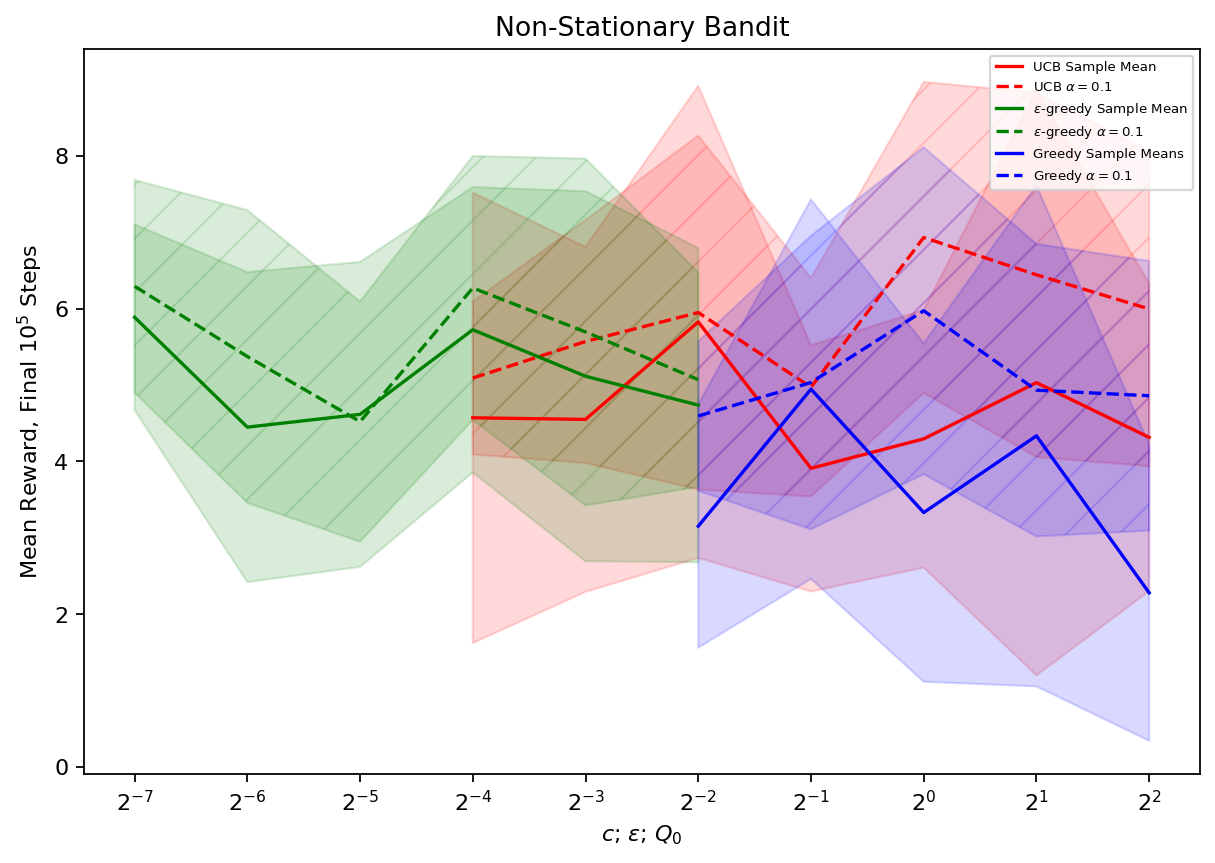

In [23]:
plt.figure(figsize=(9, 6), dpi=160)
line_styles = ["r-", "r--", "g-", "g--", "b-", "b--"]
hatches = ["", "/", "", "/", "", "/"]
for exp_info, exp_results, style, hatch in zip(all_experiments, results, line_styles, hatches):
    label = exp_info[0]
    x_vals = np.log2(exp_info[1])
    mean_results = np.mean(exp_results, axis=1)
    std_results = np.std(exp_results, axis=1)
    plt.plot(x_vals, mean_results, style, label=label)
    plt.fill_between(x_vals, mean_results - std_results, mean_results + std_results, color=style[0], hatch=hatch, alpha=0.15)

plt.xlabel(r"$c$; $\epsilon$; $Q_0$")
plt.ylabel("Mean Reward, Final $10^5$ Steps")
plt.title("Non-Stationary Bandit")
x_tick_locs = list(range(-7, 3))
plt.xticks(x_tick_locs, [f"$2^{{{x}}}$" for x in x_tick_locs])
plt.legend(prop={"size": 6})
plt.savefig('comparison.pdf')